In [1]:
import sys  
sys.path.insert(0, '/home/jliu/project/')

from todata.models.sql.functions import sql_read_pd
from pycaret.regression import *



In [2]:
# extract data

power = sql_read_pd('toronto',
"""
SELECT p.ts, p.power_use_mwh, w.temp_c, w.rel_hum_pct, w.pressure_kpa, r.rain_mm,
        EXTRACT(YEAR FROM p.ts)::text AS year,
        EXTRACT(MONTH FROM p.ts)::text AS month,
        EXTRACT(ISODOW FROM p.ts)::text AS day_of_week,
        EXTRACT(HOUR FROM p.ts)::text as hour,
        CASE 
            WHEN p.ts + INTERVAL '30 minutes' BETWEEN d.rise AND d.set THEN 1
            ELSE 0
        END is_daylight,
        CASE
            WHEN h.hdate IS NULL THEN 0
            ELSE 1
        END is_holiday

    FROM power AS p
    LEFT JOIN daylight AS d ON date_trunc('day', p.ts) = date_trunc('day', d.cdate)
    LEFT JOIN weather AS w ON p.ts = w.ts
    LEFT JOIN rain as r ON p.ts = r.ts
    LEFT JOIN holiday as h ON date_trunc('day', p.ts) = date_trunc('day', h.hdate)
    ORDER BY p.ts
"""
)

In [6]:
# remove NA
power_cleaned = power.dropna()
power_cleaned = power_cleaned.loc[(power_cleaned['power_use_mwh'] != 0)]

In [7]:
reg = setup(power_cleaned, target='power_use_mwh', categorical_features=['hour'])

,Description,Value
0,session_id,5584
1,Target,power_use_mwh
2,Original Data,"(49089, 12)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(34362, 58)"


In [8]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,122.4076,27851.0524,166.8545,0.9732,0.0285,0.0213,3.8000
et,Extra Trees Regressor,121.5435,31629.0204,177.7912,0.9696,0.0303,0.0212,2.9970
xgboost,Extreme Gradient Boosting,134.7104,33813.2404,183.8310,0.9675,0.0315,0.0235,85.7620
lightgbm,Light Gradient Boosting Machine,146.2274,39148.6807,197.8262,0.9623,0.0340,0.0256,0.0950
rf,Random Forest Regressor,138.0651,39245.4387,198.0432,0.9622,0.0338,0.0241,3.3900
dt,Decision Tree Regressor,186.5195,75335.8466,274.3405,0.9275,0.0467,0.0324,0.0980
gbr,Gradient Boosting Regressor,244.4484,97996.6700,313.0080,0.9057,0.0541,0.0431,0.8890
lr,Linear Regression,388.7331,259879.8078,509.6750,0.7502,0.0868,0.0679,0.1990
ridge,Ridge Regression,388.6963,259890.4156,509.6858,0.7502,0.0867,0.0679,0.0170
br,Bayesian Ridge,388.7115,259883.1954,509.6786,0.7502,0.0867,0.0679,0.0880


In [9]:
cb = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,122.8980,27481.3068,165.7749,0.9734,0.0285,0.0215
1,120.8936,26899.7082,164.0113,0.9741,0.0281,0.0211
2,121.6059,29377.1399,171.3976,0.9710,0.0295,0.0213
3,121.3586,26533.0004,162.8895,0.9752,0.0278,0.0212
4,122.9543,27440.7692,165.6526,0.9745,0.0281,0.0213
5,121.3248,26707.8237,163.4253,0.9741,0.0281,0.0213
6,125.1302,29419.6142,171.5215,0.9727,0.0293,0.0218
7,121.7834,27778.2147,166.6680,0.9733,0.0283,0.0212
8,124.6084,29489.4710,171.7250,0.9715,0.0288,0.0216
9,121.5185,27383.4758,165.4795,0.9723,0.0281,0.0211


In [10]:
tuned_cb = tune_model(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,208.7847,72026.7486,268.3780,0.9304,0.0470,0.0371
1,209.4595,73239.6860,270.6283,0.9296,0.0473,0.0372
2,206.4859,73866.8067,271.7845,0.9272,0.0475,0.0366
3,209.1216,73409.0178,270.9410,0.9313,0.0472,0.0370
4,205.5218,71652.6063,267.6800,0.9333,0.0461,0.0359
5,202.0033,69117.8166,262.9027,0.9328,0.0459,0.0358
6,212.2805,76038.8039,275.7513,0.9296,0.0478,0.0376
7,209.1437,73908.7606,271.8617,0.9289,0.0471,0.0369
8,208.0820,76263.7743,276.1590,0.9262,0.0473,0.0365
9,209.3163,74745.5894,273.3964,0.9244,0.0474,0.0370


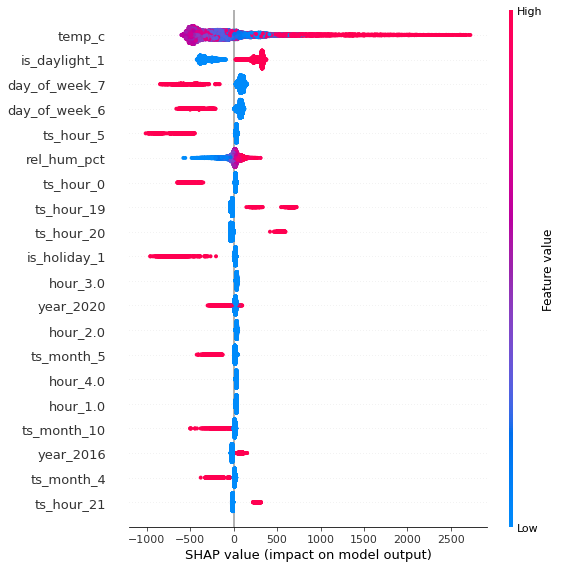

In [11]:
interpret_model(cb)

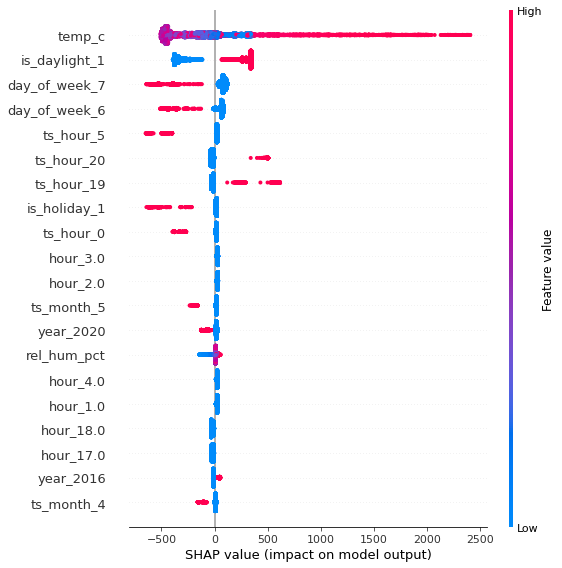

In [12]:
interpret_model(tuned_cb)